Testing out a RealNVP normalising flow with a ResNet autoencoder to model the latent space of images as a multivariate normal distribution.

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import datasets, transforms

from tqdm import tqdm
from matplotlib import pyplot as plt

import numpy as np

class Flow(nn.Module):
    def __init__(self):
        super().__init__()

    def forward(self, z):
        raise NotImplementedError("Forward pass not implemented")
    
    def inverse(self, z):
        raise NotImplementedError("Inverse pass not implemented")

/home/joel/miniconda3/envs/normflow/lib/python3.7/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Implement a masked affine coupling layer that operates directly on the latent vector produced by ResNet.

In [2]:
class LatentMaskedAffineCoupling(Flow):
    def __init__(self, b, net):
        super().__init__()
        self.register_buffer('b', b)
        self.net = net
        self.scaling = nn.Parameter(torch.zeros(1))

    def forward(self, z):
        z_masked = self.b * z
        s, t = self.net(z_masked).chunk(2, dim=1)

        s_exp = self.scaling.exp()
        s = torch.tanh(s / s_exp) * s_exp

        z_out = z_masked + (1 - self.b) * (z * torch.exp(s) + t)
        log_det = torch.sum((1 - self.b) * s, dim=list(range(1, self.b.dim())))
        return z_out, log_det

    def inverse(self, z):
        z_masked = self.b * z
        s, t = self.net(z_masked).chunk(2, dim=1)
        
        s_exp = self.scaling.exp()
        s = torch.tanh(s / s_exp) * s_exp

        z_out = z_masked + (1 - self.b) * (z - t) * torch.exp(-s)
        log_det = -torch.sum((1 - self.b) * s, dim=list(range(1, self.b.dim())))
        return z_out, log_det


Implement a normalising flow class that wraps around pre-specified flow layers, and allows us to do forward passes (image latent vector -> target distribution, in this case multivariate normal), as well as to sample (sample from target distribution -> image latent vector).

In [3]:
class NormalisingFlow(nn.Module):
    def __init__(self, flows, prior, device):
        super().__init__()
        self.flows = nn.ModuleList(flows)
        self.prior = prior # Target distribution to be approximated
        self.device = device
        
    def forward(self, z):
        log_det = torch.zeros(z.shape, device=self.device)
        for flow in self.flows:
            z, local_log_det = flow(z)
            log_det += local_log_det
        return z, log_det

    def sample(self, sample_shape=None):
        if sample_shape:
            z = self.prior.sample(sample_shape=sample_shape)
        else:
            z = self.prior.sample() # No need to specify for multivariate normal

        z = z.to(self.device)
        for flow in reversed(self.flows):
            z, _ = flow.inverse(z)
        return z
    
    def get_prior_log_prob(self, z):
        return self.prior.log_prob(z)

Set up neural network classes needed for the flow layers

In [4]:
class MLP(nn.Module):
    def __init__(self, in_size, hidden_size, num_layers):
        super().__init__()
        if num_layers == 1:
            layers = [nn.Linear(in_size, 2*in_size)]
        else:
            layers = [nn.Linear(in_size, hidden_size, bias=True), nn.LeakyReLU()]
            for i in range(num_layers - 2):
                layers += [nn.Linear(hidden_size, hidden_size, bias=True), nn.LeakyReLU()]
            layers += [nn.Linear(hidden_size, 2*in_size, bias=True)]
        
        self.layers = nn.Sequential(*layers)
        
    def forward(self, x):
        return self.layers(x)

Set up the models and the hyperparameters.

In [63]:
n_bottleneck = 256
n_flows = 16
n_epochs = 10
batch_size = 64

enable_cuda = True
device = torch.device('cuda' if torch.cuda.is_available() and enable_cuda else 'cpu')

In [6]:
from pl_bolts.models.autoencoders import AE, VAE
ae = AE(input_height=32, enc_type='resnet50')
print(AE.pretrained_weights_available())
print(VAE.pretrained_weights_available())
ae = ae.from_pretrained('resnet50-imagenet')
# ae.freeze()
# ae = ae.to(device)

['cifar10-resnet18']
['cifar10-resnet18', 'stl10-resnet18']


KeyError: 'resnet50-imagenet not present in pretrained weights.'

In [65]:
# Specify the flow layers
b = torch.tensor(n_bottleneck // 2 * [0, 1] + n_bottleneck % 2 * [0])
flows = []
for i in range(n_flows):
    st_net = MLP(n_bottleneck, 1024, 3)
    if i % 2 == 0:
        flows += [LatentMaskedAffineCoupling(b, st_net)]
    else:
        flows += [LatentMaskedAffineCoupling(1 - b, st_net)]

# Specify the prior (target distribution)
# prior = torch.distributions.MultivariateNormal(
#     torch.zeros(n_bottleneck, device=device),
#     torch.eye(n_bottleneck, device=device)
#     )
prior = torch.distributions.normal.Normal(loc=0.0, scale=1.0)
        
# Construct the normalising flow
nf = NormalisingFlow(flows, prior, device).to(device)

Load the datasets.

In [8]:
# Transformations applied on each image => make them a tensor and discretize
transform = transforms.Compose([transforms.ToTensor()])

# Loading the training dataset. We need to split it into a training and validation part
train_dataset = datasets.CIFAR10(root="../../data", train=True, transform=transform, download=True)
train_set, val_set = torch.utils.data.random_split(train_dataset, [42000, 8000])

# Loading the test set
test_set = datasets.CIFAR10(root="../../data", train=False, transform=transform, download=True)

# Define the data loaders. We currently do not use the validation and test sets.
train_loader = torch.utils.data.DataLoader(train_set, batch_size=batch_size, shuffle=False, drop_last=False)
val_loader = torch.utils.data.DataLoader(val_set, batch_size=64, shuffle=False, drop_last=False, num_workers=4)
test_loader = torch.utils.data.DataLoader(test_set, batch_size=64, shuffle=False, drop_last=False, num_workers=4)

print("Loaded in data.")

NameError: name 'transforms' is not defined

Training the normalising flow.

In [67]:
optimizer =  torch.optim.Adam(nf.parameters(), lr=1e-4, weight_decay=1e-4)
for epoch in range(n_epochs):
    progressbar = tqdm(enumerate(train_loader), total=len(train_loader))
    for batch_n, (x, n) in progressbar:
        x = x.to(device)
        optimizer.zero_grad()
        z = ae.encoder(x)
        z = ae.fc(z)
        z, log_det = nf(z)
        log_prob_z = nf.get_prior_log_prob(z)
        loss = -log_prob_z.mean() - log_det.mean()
        loss.backward()
        optimizer.step()
        progressbar.update()
    progressbar.close()
    print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_n * len(x), len(train_loader.dataset),
                       100. * batch_n / len(train_loader),
                       loss.item()))
    
torch.save(nf.state_dict(), "../../saved_models/realnvp_16l_10p.ckpt")

100%|██████████| 657/657 [00:25<00:00, 26.14it/s]


Train Epoch: 0 [10496/42000 (100%)]	Loss: -20935.705078


100%|██████████| 657/657 [00:24<00:00, 26.80it/s]


Train Epoch: 1 [10496/42000 (100%)]	Loss: -21519.406250


100%|██████████| 657/657 [00:25<00:00, 25.29it/s]


Train Epoch: 2 [10496/42000 (100%)]	Loss: -22077.816406


100%|██████████| 657/657 [00:26<00:00, 25.24it/s]


Train Epoch: 3 [10496/42000 (100%)]	Loss: -22423.375000


100%|██████████| 657/657 [00:26<00:00, 25.18it/s]


Train Epoch: 4 [10496/42000 (100%)]	Loss: -22700.769531


100%|██████████| 657/657 [00:25<00:00, 25.90it/s]


Train Epoch: 5 [10496/42000 (100%)]	Loss: -22848.933594


100%|██████████| 657/657 [00:24<00:00, 26.73it/s]


Train Epoch: 6 [10496/42000 (100%)]	Loss: -23033.564453


100%|██████████| 657/657 [00:24<00:00, 26.83it/s]


Train Epoch: 7 [10496/42000 (100%)]	Loss: -23308.318359


100%|██████████| 657/657 [00:24<00:00, 26.83it/s]


Train Epoch: 8 [10496/42000 (100%)]	Loss: -23441.519531


100%|██████████| 657/657 [00:24<00:00, 26.68it/s]

Train Epoch: 9 [10496/42000 (100%)]	Loss: -23752.937500


Sampling from the trained normalising flow.

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


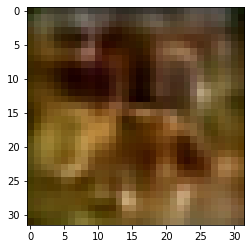

In [72]:
samples = nf.sample(sample_shape=[2, 256])
recon = ae.decoder(samples)
x_np = recon.view((2, 3, 32, 32)).to('cpu').detach().numpy()
x0 = x_np[0].swapaxes(0, 2).swapaxes(0, 1)
plt.imshow(x0)
plt.show()

Compare the results with an untrained normalising flow to see the differences.

In [36]:
# Specify the flow layers
b_clean = torch.tensor(n_bottleneck // 2 * [0, 1] + n_bottleneck % 2 * [0])
flows_clean = []
for i in range(n_flows):
    st_net_clean = MLP(n_bottleneck, 1024, 2)
    if i % 2 == 0:
        flows_clean += [LatentMaskedAffineCoupling(b_clean, st_net_clean)]
    else:
        flows_clean += [LatentMaskedAffineCoupling(1 - b_clean, st_net_clean)]

prior_clean = torch.distributions.normal.Normal(loc=0.0, scale=1.0)
        
# Construct the normalising flow
nf_clean = NormalisingFlow(flows_clean, prior_clean, device).to(device)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


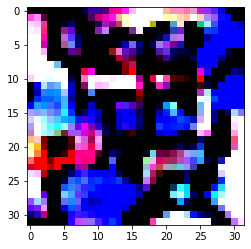

In [23]:
samples = nf_clean.sample(sample_shape=[2, 256])
recon = ae.decoder(samples)
x_np = recon.view((2, 3, 32, 32)).to('cpu').detach().numpy()
x0 = x_np[0].swapaxes(0, 2).swapaxes(0, 1)
plt.imshow(x0)
plt.show()